In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_ema(dir, y_label):
    dir = dir
    # === Einstellungen ===
    dateien = [Path(dir, file) for file in os.listdir(dir)]
    sep = ","         # bei deutschen CSVs: sep=";", decimal=","
    decimal = "."
    ema_span = 50     # EMA-Fenstergröße (z. B. 10, 30, 60)

    plt.figure()
    for pfad in dateien:
        df = pd.read_csv(pfad, sep=sep, decimal=decimal, usecols=["Step", "Value"])
        # Nach Step sortieren, damit EMA in richtiger Reihenfolge läuft
        df = df.sort_values("Step").reset_index(drop=True)

        # EMA berechnen
        df["EMA"] = df["Value"].ewm(span=ema_span, adjust=False).mean()

        # Plot pro Datei (Label aus Dateiname)
        label = Path(pfad).stem
        plt.plot(df["Step"], df["EMA"], label=f"{label}")

    plt.title(dir)
    plt.xlabel("Step")
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{dir}.eps")
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


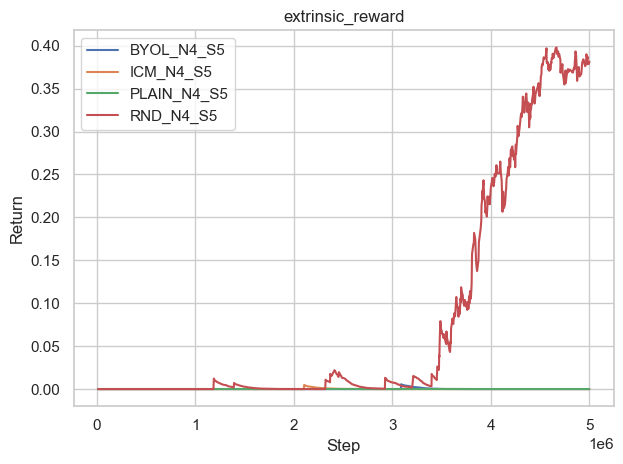

In [35]:
plot_ema("extrinsic_reward", "Return")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


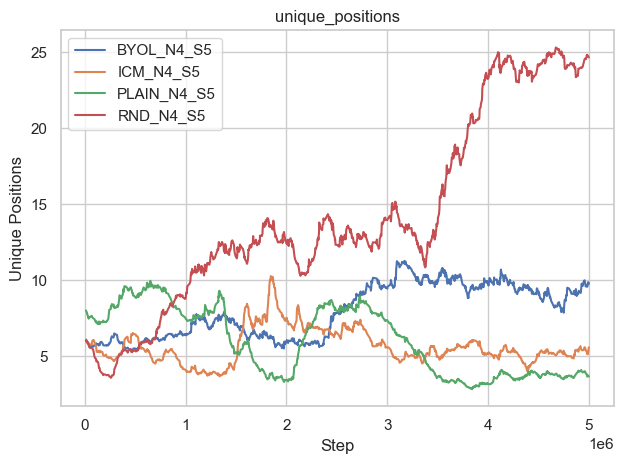

In [36]:
plot_ema("unique_positions", "Unique Positions")

In [45]:
import os
import gymnasium as gym
import numpy as np
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

from src.config import Config
from src.envs.action_wrapper import SaveActionWrapper

def make_env(cfg):
    # Für Auswertung ohne Fenster:
    env = gym.make(cfg.env_name, render_mode=None, max_steps=cfg.max_steps)
    env = RGBImgPartialObsWrapper(env)
    env = ImgObsWrapper(env)
    env = SaveActionWrapper(env, list(cfg.allowed_actions))
    env.action_space = gym.spaces.discrete.Discrete(cfg.action_dim)
    return env

def evaluate_model(model_path, n_episodes=1000, device='cuda', deterministic=True):
    cfg = Config()
    cfg.set_seed()

    # Modell laden (nur Policy + Recurrent States)
    model = RecurrentPPO.load(model_path, device=device, seed=cfg.seed)

    # VecEnv bauen
    env = make_env(cfg)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(cfg.seed)

    # Modell mit Env verknüpfen (wichtig für predict in SB3)
    model.set_env(vec_env)

    # Sammelgrößen
    success_episodes = 0
    unique_positions_per_episode = []

    # Recurrent-Handling
    lstm_states = None
    num_envs = 1
    episode_starts = np.ones((num_envs,), dtype=bool)

    # Episoden-Schleife
    episodes_done = 0
    obs = vec_env.reset()

    # Positions-Set für die aktuelle Episode
    episode_positions = set()

    while episodes_done < n_episodes:
        # Agenten-Position mitschneiden (vor Schritt)
        pos = tuple(vec_env.envs[0].unwrapped.agent_pos)
        episode_positions.add(pos)

        action, lstm_states = model.predict(
            obs,
            state=lstm_states,
            episode_start=episode_starts,
            deterministic=deterministic
        )
        obs, rewards, dones, infos = vec_env.step(action)

        # Position nach Schritt ebenfalls mitschneiden
        pos = tuple(vec_env.envs[0].unwrapped.agent_pos)
        episode_positions.add(pos)

        if dones[0]:
            # Erfolg: positiver End-Reward
            if float(rewards[0]) > 0.0:
                success_episodes += 1

            # Anzahl unique Positions dieser Episode speichern
            unique_positions_per_episode.append(len(episode_positions))

            episodes_done += 1

            # Nächste Episode vorbereiten
            episode_starts = np.ones((num_envs,), dtype=bool)
            lstm_states = None
            obs = vec_env.reset()

            # Neues Set für nächste Episode
            episode_positions = set()
        else:
            episode_starts = np.zeros((num_envs,), dtype=bool)

    vec_env.close()

    # Durchschnitt über Episoden
    avg_unique_positions = float(np.mean(unique_positions_per_episode)) if unique_positions_per_episode else 0.0

    return {
        "model_path": model_path,
        "success_episodes": success_episodes,
        "unique_positions_per_episode": unique_positions_per_episode,  # Liste der Längen je Episode
        "avg_unique_positions_per_episode": avg_unique_positions,      # Durchschnitt
        "n_episodes": n_episodes,
    }


In [ ]:
# Trage hier deine vier Modellpfade ein
model_paths = [
    "../models/RND/RND_checkpoint_5000000_steps_no_decay.zip",
    "../models/ICM/ICM_checkpoint_5000000_steps_no_decay.zip",
    "../models/BYOL/BYOL_checkpoint_5000000_steps_no_decay.zip",
    "../models/PLAIN/PLAIN_checkpoint_5000000_steps_no_decay.zip",
]

N_EPISODES = 1_000
DEVICE = "cuda"  # oder "cpu"

results = []
for mp in model_paths:
    if not os.path.exists(mp):
        print(f"Warnung: Modell nicht gefunden: {mp}")
        continue
    print(f"Evaluierung startet für: {mp}")
    res = evaluate_model(
        model_path=mp,
        n_episodes=N_EPISODES,
        device=DEVICE,
        deterministic=True
    )
    results.append(res)
    print(f"Done: {mp}")
    print(f"  Mean unique positions per episode: {res['avg_unique_positions_per_episode']} ")
    print(f"  Goal reached: {res['success_episodes']} / {N_EPISODES}")
    print("-" * 60)

# Optionale tabellarische Ausgabe
if results:
    print("\nZusammenfassung:")
    for r in results:
        print(f"- {os.path.basename(r['model_path'])}: "
              f"Unique Positions = {r['avg_unique_positions_per_episode']}, "
              f"Erfolge = {r['success_episodes']} von {N_EPISODES}")

Evaluierung startet für: ../models/RND/RND_checkpoint_5000000_steps_no_decay.zip
Wrapping the env in a VecTransposeImage.
